# build molecule, taper and construct CS-VQE model

In [31]:
import json
import numpy as np
from symmer.chem import MoleculeBuilder
from symmer.projection import QubitTapering, CS_VQE, StabilizerIdentification
from symmer.symplectic import ObservableGraph, PauliwordOp

with open('../data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)    

speciesname = 'Be_STO-3G_SINGLET'
print(speciesname)
# build the molecule
mol_data = molecule_geometries[speciesname]
atoms  = mol_data['atoms']
coords = mol_data['coords']
charge = mol_data['charge']
basis = mol_data['basis']
geometry = list(zip(atoms, coords))
molecule = MoleculeBuilder(geometry=geometry, charge=charge, basis=basis, spin=0, run_fci=True, print_info=True)

Be_STO-3G_SINGLET
Molecule geometry:
Be	0	0	0

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -14.351880476202023
MP2 energy:  -14.376238850841515
CCSD energy: -14.403650751752787
FCI energy:  -14.403655108067682


Number of qubits: 10


In [32]:
# taper the Hamiltonian
qubit_tapering = QubitTapering(molecule.H_q)
hf_array = molecule.H_fermion.hf_comp_basis_state
qubit_tapering.stabilizers.update_sector(hf_array)
ham_tap = qubit_tapering.taper_it(ref_state=hf_array)
ucc_tap = qubit_tapering.taper_it(aux_operator=molecule.UCC_q, ref_state=hf_array)
hf_tapered = qubit_tapering.tapered_ref_state

print(f'Qubit tapering permitted a reduction of {molecule.H_q.n_qubits} -> {ham_tap.n_qubits} qubits\n')
print('The following stabilizers were identified:\n')
print(qubit_tapering.stabilizers)

Qubit tapering permitted a reduction of 10 -> 5 qubits

The following stabilizers were identified:

 1 ZIZIIZIZIZ 
 1 IZIZIZIZIZ 
 1 IIIIZZIIII 
 1 IIIIIIZZII 
 1 IIIIIIIIZZ


In [34]:
n_qubits = 3
# CS-VQE and stabilizer identification
cs_vqe = CS_VQE(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap, noncontextual_form='diag')
CC_stabilizers = StabilizerIdentification(ucc_tap)
S = CC_stabilizers.symmetry_basis_by_subspace_dimension(n_qubits)
ham_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False)
ham_cs

-12.489+0.000j III +
-0.858+0.000j IIZ +
-0.858+0.000j IZI +
0.023+0.000j IZZ +
-0.858+0.000j ZII +
0.023+0.000j ZIZ +
0.023+0.000j ZZI +
0.642+0.000j ZZZ +
-0.043+0.000j IIX +
-0.043+0.000j ZZX +
-0.043+0.000j IXI +
-0.043+0.000j ZXZ +
0.012+0.000j IXX +
0.012+0.000j IYY +
-0.043+0.000j XII +
-0.043+0.000j XZZ +
0.012+0.000j XIX +
0.012+0.000j YIY +
0.012+0.000j XXI +
0.012+0.000j YYI

In [35]:
from symmer.symplectic import QuantumState, array_to_QuantumState
from symmer.utils import exact_gs_energy

gs_energy, gs_vec = exact_gs_energy(ham_cs.to_sparse_matrix)
gs_psi = array_to_QuantumState(gs_vec)

print(gs_psi)
print()
print(f'Contextual subspace ground state error = {gs_energy - molecule.fci_energy}')

-0.9461446877+0.0000000000j |000> +
-0.1869137323+0.0000000000j |001> +
-0.1869137323+0.0000000000j |010> +
-0.1869137323+0.0000000000j |100>

Contextual subspace ground state error = 0.0003265059338524168


In [36]:
from symmer.symplectic import AnsatzOp, ObservableOp

ucc_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False, aux_operator=ucc_tap)
ref_cs = hf_tapered[cs_vqe.free_qubit_indices]
anz_cs = AnsatzOp(ucc_cs.symp_matrix, ucc_cs.coeff_vec)

#ucc_trunc = ucc_cs#.sort()[:40]
#anz_cs = AnsatzOp(ucc_trunc.symp_matrix, ucc_trunc.coeff_vec)

obs = ObservableOp(ham_cs.symp_matrix, ham_cs.coeff_vec)
vqe_result = obs.VQE(
    ansatz_op=anz_cs, 
    ref_state=ref_cs
)

#opt_params = vqe_result[0]['x']
vqe_result[0]['fun'] - molecule.fci_energy

0.0003265823239786414

In [40]:
hf_array

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [75]:
theta=np.random.random(molecule.UCC_q.n_terms)
UCC = molecule.UCC_q[0]**0
for index, P in enumerate(molecule.UCC_q):
    UCC *= (P**0).multiply_by_constant(np.cos(theta[index])) + (P**1).multiply_by_constant(1j*np.sin(theta[index]))
psi = QuantumState([hf_array])
print(psi)
print((UCC*psi).cleanup(zero_threshold=1e-6))

 1.0000000000 |1111000000>



In [76]:
print(molecule.UCC_q*psi)

 0.0000000000+0.0008464499j |0011000011> +
 0.0000000000+0.0008464499j |0011001100> +
 0.0000000000+0.0008464499j |0011110000> +
 0.0000000000+0.0035553592j |0110000011> +
 0.0000000000+0.0035553592j |0110001100> +
 0.0000000000+0.0035553592j |0110110000> +
 0.0000000000-0.0035553592j |1001000011> +
 0.0000000000-0.0035553592j |1001001100> +
 0.0000000000-0.0035553592j |1001110000> +
 0.0000000000+0.1969535886j |1100000011> +
 0.0000000000+0.1969535886j |1100001100> +
 0.0000000000+0.1969535886j |1100110000>


In [67]:
UCC

0.000+0.000j IIIIIIIIII +
-0.000+0.000j IIIIIIIIZZ +
0.000+0.000j IIIIIIIZIZ +
0.000+0.000j IIIIIIIZZI +
0.000+0.000j IIIIIIZIIZ +
0.000+0.000j IIIIIIZIZI +
-0.000+0.000j IIIIIIZZII +
0.000+0.000j IIIIIIZZZZ +
0.000+0.000j IIIIIZIIIZ +
0.000+0.000j IIIIIZIIZI +
0.000+0.000j IIIIIZIZII +
-0.000+0.000j IIIIIZIZZZ +
0.000+0.000j IIIIIZZIII +
-0.000+0.000j IIIIIZZIZZ +
-0.000+0.000j IIIIIZZZIZ +
-0.000+0.000j IIIIIZZZZI +
0.000+0.000j IIIIZIIIIZ +
0.000+0.000j IIIIZIIIZI +
0.000+0.000j IIIIZIIZII +
-0.000+0.000j IIIIZIIZZZ +
0.000+0.000j IIIIZIZIII +
-0.000+0.000j IIIIZIZIZZ +
-0.000+0.000j IIIIZIZZIZ +
-0.000+0.000j IIIIZIZZZI +
-0.000+0.000j IIIIZZIIII +
0.000+0.000j IIIIZZIIZZ +
-0.000+0.000j IIIIZZIZIZ +
-0.000+0.000j IIIIZZIZZI +
-0.000+0.000j IIIIZZZIIZ +
-0.000+0.000j IIIIZZZIZI +
0.000+0.000j IIIIZZZZII +
-0.000+0.000j IIIIZZZZZZ +
0.000+0.000j IIIZIIIIIZ +
0.000+0.000j IIIZIIIIZI +
0.000+0.000j IIIZIIIZII +
-0.000+0.000j IIIZIIIZZZ +
0.000+0.000j IIIZIIZIII +
-0.000+0.000j IIIZIIZ

In [45]:
ref_cs

array([0, 0, 0])

In [37]:
from qiskit import QuantumCircuit
ansatz = QuantumCircuit(n_qubits)
for i in np.where(ref_cs)[0]:
    ansatz.x(n_qubits-1-i)
ansatz = ansatz.compose(anz_cs.to_QuantumCircuit(bind_params=False))
ansatz.draw()

░ ┌─────┐┌───┐┌─────────────┐┌───┐┌───┐ ░ ┌─────┐┌───┐          »
q_0: ─░─┤ Sdg ├┤ H ├┤ Rz(-2*P[0]) ├┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├──■───────»
      ░ └─────┘└───┘└─────────────┘└───┘└───┘ ░ └─────┘└───┘┌─┴─┐     »
q_1: ─░───────────────────────────────────────░─────────────┤ X ├──■──»
      ░                                       ░             └───┘┌─┴─┐»
q_2: ─░───────────────────────────────────────░──────────────────┤ X ├»
      ░                                       ░                  └───┘»
«                              ┌───┐┌───┐ ░                                 »
«q_0: ──────────────────────■──┤ H ├┤ S ├─░─────────────────────────────────»
«                         ┌─┴─┐└───┘└───┘ ░ ┌─────┐┌───┐┌─────────────┐┌───┐»
«q_1: ─────────────────■──┤ X ├───────────░─┤ Sdg ├┤ H ├┤ Rz(-2*P[2]) ├┤ H ├»
«     ┌─────────────┐┌─┴─┐└───┘           ░ └─────┘└───┘└─────────────┘└───┘»
«q_2: ┤ Rz(-2*P[1]) ├┤ X ├────────────────░─────────────────────────────────»
«     └─────────────┘└───┘                ░                                 »
«           ░                                                           ░ »
«q_0: ──────░───────────────■─────────────────────────────■─────────────░─»
«     ┌───┐ ░ ┌─────┐┌───┐┌─┴─┐                         ┌─┴─┐┌───┐┌───┐ ░ »
«q_1: ┤ S ├─░─┤ Sdg ├┤ H ├┤ X ├──■───────────────────■──┤ X ├┤ H ├┤ S ├─░─»
«     └───┘ ░ └─────┘└───┘└───┘┌─┴─┐┌─────────────┐┌─┴─┐└───┘└───┘└───┘ ░ »
«q_2: ──────░──────────────────┤ X ├┤ Rz(-2*P[3]) ├┤ X ├────────────────░─»
«           ░                  └───┘└─────────────┘└───┘                ░ »
«                                           ░                                 »
«q_0: ──────────────────────────────────────░────■────────────────────────────»
«                                           ░  ┌─┴─┐                          »
«q_1: ──────────────────────────────────────░──┤ X ├────────■─────────────────»
«     ┌─────┐┌───┐┌─────────────┐┌───┐┌───┐ ░ ┌┴───┴┐┌───┐┌─┴─┐┌─────────────┐»
«q_2: ┤ Sdg ├┤ H ├┤ Rz(-2*P[4]) ├┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├┤ X ├┤ Rz(-2*P[5]) ├»
«     └─────┘└───┘└─────────────┘└───┘└───┘ ░ └─────┘└───┘└───┘└─────────────┘»
«                     ░ 
«q_0: ───────■────────░─
«          ┌─┴─┐      ░ 
«q_1: ──■──┤ X ├──────░─
«     ┌─┴─┐├───┤┌───┐ ░ 
«q_2: ┤ X ├┤ H ├┤ S ├─░─
«     └───┘└───┘└───┘ ░

In [9]:
#from qiskit.quantum_info import Statevector
#from symmer.symplectic import QuantumState
#qc = ansatz.bind_parameters(opt_params)
#psi = Statevector.from_instruction(qc).to_dict()
#state_matrix, coeff_vec = zip(*[([int(i) for i in bstring], coeff) for bstring, coeff in psi.items()])
#state_matrix = np.array(state_matrix)
#coeff_vec = np.array(coeff_vec)

#psi = QuantumState(state_matrix, coeff_vec)
#psi.conjugate * ham_cs * psi - molecule.fci_energy

In [12]:
from qiskit.circuit.library import EfficientSU2
ansatz = EfficientSU2(n_qubits)#, reps=1)
ansatz.decompose().draw()

┌──────────┐┌──────────┐          ┌──────────┐┌──────────┐             »
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├──■────■──┤ Ry(θ[6]) ├┤ Rz(θ[9]) ├─────────────»
     ├──────────┤├──────────┤┌─┴─┐  │  └──────────┘├──────────┤┌───────────┐»
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├┤ X ├──┼───────■──────┤ Ry(θ[7]) ├┤ Rz(θ[10]) ├»
     ├──────────┤├──────────┤└───┘┌─┴─┐   ┌─┴─┐    ├──────────┤├───────────┤»
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├─────┤ X ├───┤ X ├────┤ Ry(θ[8]) ├┤ Rz(θ[11]) ├»
     └──────────┘└──────────┘     └───┘   └───┘    └──────────┘└───────────┘»
«               ┌───────────┐┌───────────┐                       ┌───────────┐»
«q_0: ──■────■──┤ Ry(θ[12]) ├┤ Rz(θ[15]) ├───────────────■────■──┤ Ry(θ[18]) ├»
«     ┌─┴─┐  │  └───────────┘├───────────┤┌───────────┐┌─┴─┐  │  └───────────┘»
«q_1: ┤ X ├──┼────────■──────┤ Ry(θ[13]) ├┤ Rz(θ[16]) ├┤ X ├──┼────────■──────»
«     └───┘┌─┴─┐    ┌─┴─┐    ├───────────┤├───────────┤└───┘┌─┴─┐    ┌─┴─┐    »
«q_2: ─────┤ X ├────┤ X ├────┤ Ry(θ[14]) ├┤ Rz(θ[17]) ├─────┤ X ├────┤ X ├────»
«          └───┘    └───┘    └───────────┘└───────────┘     └───┘    └───┘    »
«     ┌───────────┐             
«q_0: ┤ Rz(θ[21]) ├─────────────
«     ├───────────┤┌───────────┐
«q_1: ┤ Ry(θ[19]) ├┤ Rz(θ[22]) ├
«     ├───────────┤├───────────┤
«q_2: ┤ Ry(θ[20]) ├┤ Rz(θ[23]) ├
«     └───────────┘└───────────┘

In [77]:
#import qiskit.circuit.library.n_local as lib_local

#ansatz = getattr(lib_local, "EfficientSU2")
#ansatz(3).decompose().draw()

# VQE using ``symmer-vqe-Ve6OdoVd8X`` runtime program

In [78]:
from qiskit_ibm_runtime import QiskitRuntimeService
# only run the following the first time you connect to the service
#token = "a26e0769ddee03aa5f95f38edb1266efa1190059c7d60c1784ca3ec1e4c3c84bc375947c2bc8d2bc4ab39e32ea64ae6376b1f631936a416c7b8bdaed8b94a9cb"
#QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')

In [79]:
#program_id = service.upload_program(data="../../symmer/simulation/vqe_runtime.py", metadata=meta)
program_id = 'symmer-vqe-Ve6OdoVd8X'

In [80]:
#service.update_program(program_id=program_id, data="../../symmer/simulation/vqe_runtime.py", metadata=meta)
# service.delete_program(program_id) # to delete program

In [81]:
prog = service.program(program_id)
print(f'Program name: {prog.name}')
print(f'Description:  {prog.description}')

Program name: symmer_vqe
Description:  VQE program using symmer


In [82]:
operator = ham_cs

QWC_decomposition = list(
    ObservableGraph(
        operator.symp_matrix, 
        operator.coeff_vec
    ).clique_cover(
        clique_relation='QWC', 
        colouring_strategy='largest_first'
    ).values()
)
assert(sum(QWC_decomposition)==operator), 'Decomposition into QWC groups failed'

In [83]:
for name in service.backends():
    print(f'Backend name: {name.name: <29} | '+
          f'Number of qubits: {name.num_qubits: <4} | '+
          f'Number of jobs queued: {name.status().pending_jobs}'
    )

Backend name: ibmq_qasm_simulator           | Number of qubits: 32   | Number of jobs queued: 1
Backend name: ibmq_armonk                   | Number of qubits: 1    | Number of jobs queued: 1
Backend name: ibmq_lima                     | Number of qubits: 5    | Number of jobs queued: 28
Backend name: ibmq_belem                    | Number of qubits: 5    | Number of jobs queued: 29
Backend name: ibmq_quito                    | Number of qubits: 5    | Number of jobs queued: 30
Backend name: simulator_statevector         | Number of qubits: 32   | Number of jobs queued: 3
Backend name: simulator_mps                 | Number of qubits: 100  | Number of jobs queued: 3
Backend name: simulator_extended_stabilizer | Number of qubits: 63   | Number of jobs queued: 3
Backend name: simulator_stabilizer          | Number of qubits: 5000 | Number of jobs queued: 2
Backend name: ibmq_manila                   | Number of qubits: 5    | Number of jobs queued: 212
Backend name: ibm_nairobi          

In [155]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2

excitation_circuit = anz_cs.to_QuantumCircuit(bind_params=False)
#excitation_circuit = EfficientSU2(n_qubits, su2_gates=['rx', 'ry'], entanglement='circular', reps=2, insert_barriers=True)

ansatz = QuantumCircuit(n_qubits)
for i in np.where(ref_cs)[0]:
    ansatz.x(n_qubits-1-i)
ansatz.barrier()
ansatz = ansatz.compose(excitation_circuit)

ansatz.draw()

░  ░ ┌─────┐┌───┐┌─────────────┐┌───┐┌───┐ ░ ┌─────┐┌───┐          »
q_0: ─░──░─┤ Sdg ├┤ H ├┤ Rz(-2*P[0]) ├┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├──■───────»
      ░  ░ └─────┘└───┘└─────────────┘└───┘└───┘ ░ └─────┘└───┘┌─┴─┐     »
q_1: ─░──░───────────────────────────────────────░─────────────┤ X ├──■──»
      ░  ░                                       ░             └───┘┌─┴─┐»
q_2: ─░──░───────────────────────────────────────░──────────────────┤ X ├»
      ░  ░                                       ░                  └───┘»
«                              ┌───┐┌───┐ ░                                 »
«q_0: ──────────────────────■──┤ H ├┤ S ├─░─────────────────────────────────»
«                         ┌─┴─┐└───┘└───┘ ░ ┌─────┐┌───┐┌─────────────┐┌───┐»
«q_1: ─────────────────■──┤ X ├───────────░─┤ Sdg ├┤ H ├┤ Rz(-2*P[2]) ├┤ H ├»
«     ┌─────────────┐┌─┴─┐└───┘           ░ └─────┘└───┘└─────────────┘└───┘»
«q_2: ┤ Rz(-2*P[1]) ├┤ X ├────────────────░─────────────────────────────────»
«     └─────────────┘└───┘                ░                                 »
«           ░                                                           ░ »
«q_0: ──────░───────────────■─────────────────────────────■─────────────░─»
«     ┌───┐ ░ ┌─────┐┌───┐┌─┴─┐                         ┌─┴─┐┌───┐┌───┐ ░ »
«q_1: ┤ S ├─░─┤ Sdg ├┤ H ├┤ X ├──■───────────────────■──┤ X ├┤ H ├┤ S ├─░─»
«     └───┘ ░ └─────┘└───┘└───┘┌─┴─┐┌─────────────┐┌─┴─┐└───┘└───┘└───┘ ░ »
«q_2: ──────░──────────────────┤ X ├┤ Rz(-2*P[3]) ├┤ X ├────────────────░─»
«           ░                  └───┘└─────────────┘└───┘                ░ »
«                                           ░                                 »
«q_0: ──────────────────────────────────────░────■────────────────────────────»
«                                           ░  ┌─┴─┐                          »
«q_1: ──────────────────────────────────────░──┤ X ├────────■─────────────────»
«     ┌─────┐┌───┐┌─────────────┐┌───┐┌───┐ ░ ┌┴───┴┐┌───┐┌─┴─┐┌─────────────┐»
«q_2: ┤ Sdg ├┤ H ├┤ Rz(-2*P[4]) ├┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├┤ X ├┤ Rz(-2*P[5]) ├»
«     └─────┘└───┘└─────────────┘└───┘└───┘ ░ └─────┘└───┘└───┘└─────────────┘»
«                     ░ 
«q_0: ───────■────────░─
«          ┌─┴─┐      ░ 
«q_1: ──■──┤ X ├──────░─
«     ┌─┴─┐├───┤┌───┐ ░ 
«q_2: ┤ X ├┤ H ├┤ S ├─░─
«     └───┘└───┘└───┘ ░

In [120]:
backend_name = 'ibmq_qasm_simulator' #'ibm_nairobi'

options = {
    'backend_name': backend_name
}

inputs = {
    "ansatz": ansatz,
    "observable": ham_cs.to_PauliSumOp,
    "observable_groups": [op.to_PauliSumOp for op in QWC_decomposition],
    "init_params": np.zeros(ansatz.num_parameters),
    "optimizer": 'SLSQP',
    "n_groups":5,
    "opt_setting": {"maxiter":50, "gtol": 1e-6},
    "n_shots": 2**15, # 18 < np.log2(0.0016**-2) < 19
    "n_realize":5,
    "mitigate_errors": True
}

In [121]:
job = service.run(
    program_id=program_id, 
    options=options, 
    inputs=inputs,
    instance='ibm-q/open/main'
)

In [122]:
service.backend(backend_name).status()

In [124]:
#job = service.job('cb3bmkqoit2rk73c3csg')
print(f'Job ID: {job.job_id}')
print(f'Job status: {job.status()}')
#print(job.error_message())

Job ID: cb3bqg4t7176dht5hko0
Job status: JobStatus.RUNNING


In [125]:
job_lima = 'cb2pidaoit2rk73bcn80'
job_oslo = 'cb2lmvhvfe660br02n5g'

In [148]:
print(molecule.hf_energy, molecule.fci_energy)
job.interim_results()

-14.351880476202023 -14.403655108067682


['VQE complete',
 'Optimization step #19: energy = -14.402434894060951',
 'Optimization step #18: energy = -14.404962898741593',
 'Optimization step #17: energy = -14.402665688469435',
 'Optimization step #16: energy = -14.403009737061192',
 'Optimization step #15: energy = -14.403216129910993',
 'Optimization step #14: energy = -14.401641415530255',
 'Optimization step #13: energy = -14.401627014320443',
 'Optimization step #12: energy = -14.40201978487839',
 'Optimization step #11: energy = -14.399775900012676',
 'Optimization step #10: energy = -14.401975554810255',
 'Optimization step #9: energy = -14.401045308890847',
 'Optimization step #8: gradient norm = 0.025660958266939527',
 'Optimization step #8: energy = -14.407056269712996',
 'Optimization step #7: gradient norm = 0.023490534472125717',
 'Optimization step #7: energy = -14.404340790059843',
 'Optimization step #6: gradient norm = 0.022785041040168503',
 'Optimization step #6: energy = -14.403487875619211',
 'Optimization 

In [149]:
vqe_result, interim_values = job.result()

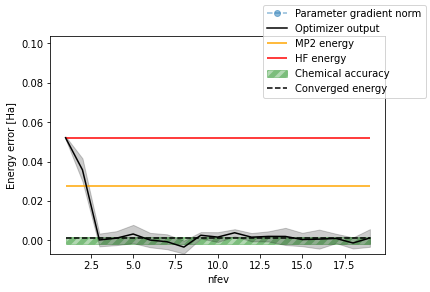

In [150]:
from matplotlib import pyplot as plt

plt.rc('hatch', color='k', linewidth=5)
fig, axis = plt.subplots()
#while not job.status().value == 'job has successfully run':
X,Y_stddev = zip(*interim_values['stddev'])
X,Y = zip(*interim_values['values'])
X,Y = np.array(X), np.array(Y)
axis.hlines(molecule.mp2_energy - molecule.fci_energy, 1, len(X), color='orange', label='MP2 energy')
axis.hlines(molecule.hf_energy - molecule.fci_energy, 1, len(X), color='red', label='HF energy')
#axis.hlines(2*0.0016, 1, len(X), color='green', label='Chemical accuracy * 2')
#axis.hlines(0.0016, 1, len(X), color='lime', label='Chemical accuracy')
#axis.hlines(-0.0016, 1, len(X), color='lime', label='Chemical accuracy')
axis.fill_between(X, -0.0016, 0.0016, alpha=0.3, color='green', label='Chemical accuracy', hatch=r"//")
axis.plot([], [], alpha=0.5, marker='o', ls='--', label='Parameter gradient norm')

Y_error = Y - molecule.fci_energy
Y_lower = Y_error - Y_stddev
Y_upper = Y_error + Y_stddev
axis.plot(X, Y_error, color='black', label='Optimizer output')
axis.hlines(vqe_result['fun'] - molecule.fci_energy, 1, len(X), color='black', label='Converged energy', ls='--')
plt.fill_between(X, Y_lower, Y_upper, alpha=0.2, color='black')

axis.set_xlabel('nfev')
axis.set_ylabel('Energy error [Ha]')
axis.set_ylim([np.min(Y_error)*2,(molecule.hf_energy-molecule.fci_energy)*2])
#axis.set_yscale('log')

#try:
#    axis_param = axis.twinx()
#    X_grad, Y_grads = zip(*interim_values['gradients'])
#    Y_grad_norm = [np.sqrt(np.sum(np.square(grad))) for grad in Y_grads]
#    axis_param.plot(X_grad, Y_grad_norm, alpha=0.5, marker='o', ls='--')
#    axis_param.set_ylabel('Parameter gradient norm $||\Delta||$')
    #for param_grad in zip(*Y_grads):
    #    axis_param.plot(X_grad, param_grad, alpha=0.2)
#except:
#    pass

fig.legend()
plt.show()

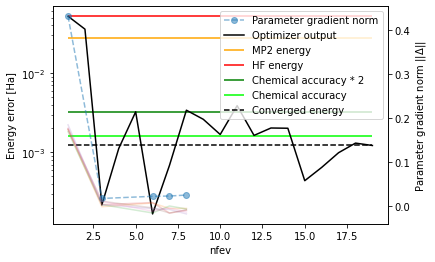

In [151]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots()
#while not job.status().value == 'job has successfully run':
X,Y = zip(*interim_values['values'])
X,Y = np.array(X), np.array(Y)
axis.hlines(molecule.mp2_energy - molecule.fci_energy, 1, len(X), color='orange', label='MP2 energy')
axis.hlines(molecule.hf_energy - molecule.fci_energy, 1, len(X), color='red', label='HF energy')
axis.hlines(2*0.0016, 1, len(X), color='green', label='Chemical accuracy * 2')
axis.hlines(0.0016, 1, len(X), color='lime', label='Chemical accuracy')
axis.plot([], [], alpha=0.5, marker='o', ls='--', label='Parameter gradient norm')


axis.plot(X, abs(Y - molecule.fci_energy), color='black', label='Optimizer output')
axis.hlines(abs(vqe_result['fun'] - molecule.fci_energy), 1, len(X), color='black', label='Converged energy', ls='--')

axis.set_xlabel('nfev')
axis.set_ylabel('Energy error [Ha]')
axis.set_yscale('log')

try:
    axis_param = axis.twinx()
    X_grad, Y_grads = zip(*interim_values['gradients'])
    Y_grad_norm = [np.sqrt(np.sum(np.square(grad))) for grad in Y_grads]
    axis_param.plot(X_grad, Y_grad_norm, alpha=0.5, marker='o', ls='--')
    axis_param.set_ylabel('Parameter gradient norm $||\Delta||$')
    for param_grad in zip(*Y_grads):
        axis_param.plot(X_grad, param_grad, alpha=0.2)
except:
    pass

axis.legend()
plt.show()

# program metadata

In [9]:
meta = {
    "name": "symmer_vqe",
    "description": "VQE program using symmer",
    "max_execution_time": 100000,
    "spec": {},
}

In [10]:
meta["spec"]["parameters"] = {
    "$schema": "https://json-schema.org/draft/2019-09/schema",
    "properties": {
        "ansatz": {
            "description": "Parametrized Ansatz",
            "type": "QuantumCircuit",
        },
        "observable_groups": {
            "description": "Decomposition of operator into groups, e.g. qubit-wise commuting",
            "type": "List[Union[PauliSumOp, PauliOp]]",
            "default": "None"
        },
        "observable": {
            "description": "The observable on which we wish to perform eigenvalue estimation",
            "type": "PauliSumOp",
            "default": "None",
        },
        "opt_setting": {
            "description": "Optimizer settings",
            "type": "dict",
            "default": "{'maxiter':10}",
        },
        "init_params": {
            "description": "Initial vector of parameters. This is a numpy array.",
            "type": "array",
            "default": "None",
        },
        "n_shots": {
            "description": "The number of shots used for each circuit evaluation.",
            "type": "integer",
            "default": "2**12",
        },
        "n_realize": {
            "description": "The number of realizations of each energy estimation - these are averaged over.",
            "type": "integer",
            "default": "1",
        },
        "n_groups": {
            "description": "The number of classical shadow groups.",
            "type": "integer",
            "default": "5",
        },
        "mitigate_errors": {
            "description": "Use matrix-free measurement mitigation (mthree), default=False.",
            "type": "boolean",
            "default": "False",
        },
    },
    "required": ["ansatz"],
}

meta["spec"]["return_values"] = {
    "$schema": "https://json-schema.org/draft/2019-09/schema",
    "description": "Tuple of final result in SciPy optimizer format and dictionary of interim values",
    "type": "Tuple[scipy.optimize.optimize.OptimizeResult, Dict]",
}

meta["spec"]["interim_results"] = {
    "$schema": "https://json-schema.org/draft/2019-09/schema",
    "description": "Parameter vector at current optimization step. This is a numpy array.",
    "type": "array",
}

In [372]:
100000 / 60 / 60

27.77777777777778